# Wind Speed

## Import Libraries

In [1]:
pip install keras-tcn

Note: you may need to restart the kernel to use updated packages.


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tcn import TCN
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, concatenate

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
import plotly.express as px
import os
import csv

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
# from keras.preprocessing.sequence import TimeseriesGenerator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
# from keras.preprocessing.sequence import TimeseriesGenerator

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, LSTM, Dropout, SimpleRNN
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Activation, dot
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adagrad, Nadam, Ftrl
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import keras.backend as K
import datetime
from tensorflow.keras import regularizers
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Read CSV

In [3]:
df = pd.read_csv("/kaggle/input/los-angeles/los angeles.csv",index_col='Date/Time', parse_dates=True)

In [4]:
dataset = 'LosAngeles'
savefilename = 'LosAngeles.csv'

In [5]:
df = df[df.index.minute == 0]

In [6]:
df = pd.DataFrame({'120m' : df['120m']}, index=df.index)

In [7]:
display(df)

,120m
Date/Time,
2020-01-01 00:00:00,3.25
2020-01-01 01:00:00,4.96
2020-01-01 02:00:00,5.55
2020-01-01 03:00:00,5.08
2020-01-01 04:00:00,4.86
...,...
2022-12-31 19:00:00,5.55
2022-12-31 20:00:00,14.48
2022-12-31 21:00:00,15.95


In [8]:
df.describe()

,120m
count,26304.000000
mean,3.082705
std,2.182042
min,0.020000
25%,1.510000
50%,2.570000
75%,4.260000
max,19.320000


In [9]:
df.isna().sum()

120m    0
dtype: int64

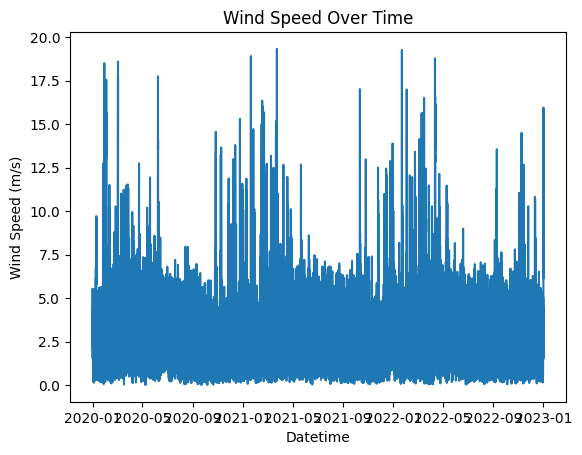

In [10]:
plt.plot(df)
plt.title('Wind Speed Over Time')
plt.xlabel('Datetime')
plt.ylabel('Wind Speed (m/s)')
plt.savefig('jaisalmer.png')
plt.show()

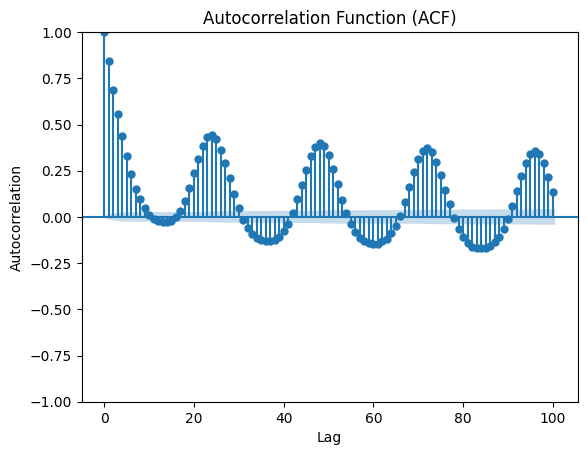

In [11]:
plot_acf(df, lags=100)  # You can adjust the number of lags as needed
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

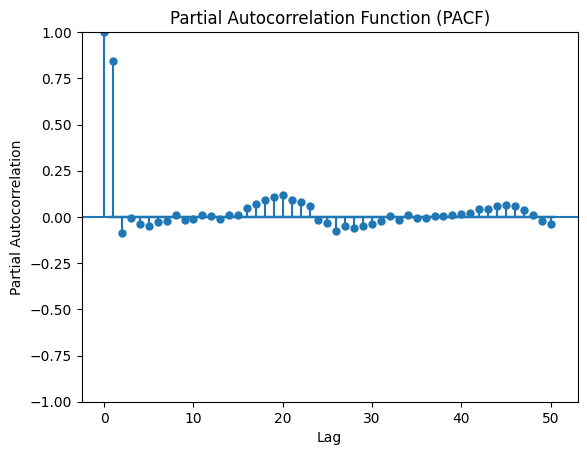

In [12]:
plot_pacf(df, lags=50)  # You can adjust the number of lags as needed
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

## Define Loss and Model

### Loss

#### QD Loss


In [13]:
from tensorflow.keras.utils import register_keras_serializable


In [14]:
# for qd_objective
# lambda_ = 0.05 # lambda in loss fn
alpha_ = 0.1  # capturing (1-alpha)% of samples
soften_ = 160. #160
n_ = 128 # batch size
lambda1 = 0.95
lambda2 = 0.05

def change_qd_var(alpha, soften, n, l1, l2):
    global alpha_, soften_, n_, lambda1, lambda2
    alpha_ = alpha
    soften_ = soften
    n_ = n
    lambda1 = l1
    lambda2 = l2

@register_keras_serializable()
def qd_objective(y_true, y_pred):
    '''Loss_QD-soft, from algorithm 1'''
    y_true = y_true[:, 0]
    y_u = y_pred[:, 0]
    y_l = y_pred[:, 1]

    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)

    # Calculate MPIW_c using tf.cond
    sum_K_S = tf.reduce_sum(K_S)
    numerator_MPIW_c = tf.reduce_sum(tf.multiply((y_u - y_l), K_S))
    MPIW_c = tf.cond(
        pred=tf.equal(sum_K_S, 0),
        true_fn=lambda: tf.constant(0.0, dtype=tf.float32),
        false_fn=lambda: numerator_MPIW_c / (sum_K_S + 1e-8)
    )

    PICP_S = tf.reduce_mean(K_S)

    penalty = tf.maximum(0.0, y_l - y_true) + tf.maximum(0.0, y_true - y_u)
    non_zero_terms = tf.boolean_mask(penalty, penalty > 0)

    # Calculate pen_loss using tf.cond
    size = tf.size(non_zero_terms)
    pen_loss = tf.cond(
        pred=tf.equal(size, 0),
        true_fn=lambda: tf.constant(0.0, dtype=tf.float32),
        false_fn=lambda: tf.reduce_mean(non_zero_terms)
    )

    Loss_S = lambda1 * MPIW_c + \
             lambda2 * n_ / (alpha_ * (1 - alpha_)) * tf.square(tf.maximum(0.0, (1 - alpha_) - PICP_S)) + \
             pen_loss
    return Loss_S

#### Confidence Loss(Tube Loss)

In [15]:
# for confidance loss
r= 0.95 # confidence {0-1}
q = 0.95
delta = 0.001 # 0.05,0.1
qq1 = 0.025
qq2 = 0.975

def change_confidence_var(r_, q_, delta_):
    global r, q, delta
    r = r_
    q = q_
    delta = delta_

def confidence_loss(y_true, y_pred):
    y_true = y_true[:, 0]
    f1 = y_pred[:, 0]
    f2 = y_pred[:, 1]

    c1 = (1 - q) * (y_true - f2)
    c2 = (1 - q) * (f1 - y_true)
    c3 = q * (f2 - y_true)
    c4 = q * (y_true - f1)

    condition1 = tf.math.logical_and(y_true <= f1, y_true >= f2)
    condition2 = y_true > (r * f1 + (1 - r) * f2)
    condition3 = f2 > y_true

    loss_part1 = tf.where(condition1,
                          tf.where(condition2, c1, c2),
                          tf.where(condition3, c3, c4))
    loss = loss_part1 + (delta * tf.math.abs(f1 - f2))
    return loss

#### Quantile Loss

In [16]:
from tensorflow.keras.saving import register_keras_serializable
@register_keras_serializable()
def quantile_loss(quantile):
    def loss(y_true, y_pred):
        e = y_true - y_pred
        return tf.reduce_mean(tf.maximum(quantile * e, (quantile - 1) * e), axis=-1)
    return loss

### LSTM Model

In [17]:
def create_lstm(input_shape, layer_units, output_units, dropout_rate=0.0):
    model = Sequential()
    for i, units in enumerate(layer_units[:-1]):
        model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape, activation="relu"))
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))  # Adding dropout between LSTM layers
    # Last LSTM layer without return_sequences
    model.add(LSTM(units=layer_units[-1], activation="relu"))
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))  # Adding dropout after the last LSTM layer
    model.add(Dense(output_units))  # Output layer
    return model

### GRU Model


In [18]:
def create_gru(input_shape, layer_units, output_units, dropout_rate=0.0):
    model = Sequential()
    for i, units in enumerate(layer_units[:-1]):
        model.add(GRU(units=units, return_sequences=True, input_shape=input_shape, activation="relu"))
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))  # Adding dropout between GRU layers
    # Last GRU layer without return_sequences
    model.add(GRU(units=layer_units[-1], activation="relu"))
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))  # Adding dropout after the last GRU layer
    model.add(Dense(output_units))  # Output layer
    return model

### TCN Model

In [19]:
# def create_tcn(input_shape, layer_units, output_units, kernel=3, dropout_rate=0.0):
#     model = Sequential()
#     # print(layer_units)
#     i=0
#     for units in layer_units[:-1]:
#         model.add(TCN(nb_filters=units, kernel_size=kernel, nb_stacks=1, dilations=[2**i], dropout_rate=dropout_rate, return_sequences=True,activation='relu'))
#         i=i+1
#     model.add(TCN(nb_filters=layer_units[-1], kernel_size=kernel, nb_stacks=1, dilations=[2**i], dropout_rate=dropout_rate,activation='relu'))
#     model.add(Dense(output_units))  # Output layer
#     return model

In [20]:
from tensorflow.keras.layers import Input, Conv1D, ReLU, Dropout, Add, Flatten, Dense
from tensorflow.keras.models import Model

def tcn_block(x, filters, kernel_size, dilation_rate, dropout_rate):
    original_x = x
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    if original_x.shape[-1] != filters:
        original_x = Conv1D(filters=filters, kernel_size=1, padding='same')(original_x)
    x = Add()([original_x, x])
    return x


In [21]:
def create_tcn(input_shape, filters_list, kernel_size, dropout_rate):
    input_layer = Input(shape=input_shape)
    x = input_layer
    dilation_rates = [2**i for i in range(len(filters_list))]
    for filters, dilation_rate in zip(filters_list, dilation_rates):
        x = tcn_block(x, filters, kernel_size, dilation_rate, dropout_rate)
    x = Flatten()(x)
    output_layer = Dense(2)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

## Train and Test

#### Split Data

In [22]:
input_window_size = 24  # window size

In [23]:
# Time-based train-test split
validation_size = 0.15
test_size = 0.15
split_index_val = int(len(df) * (1 - validation_size - test_size))
split_index_test = int(len(df) * (1 - test_size))

train_data = df[:split_index_val]
validation_data = df[split_index_val:split_index_test]
test_data = df[split_index_test:]

In [24]:
def truncate(x, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=100, test_len=20):
    in_, out_= [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
    return np.array(in_), np.array(out_)

In [25]:
train_x, train_y = truncate(train_data.values, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=input_window_size, test_len=1)
val_x, val_y = truncate(validation_data.values, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=input_window_size, test_len=1)
test_x, test_y = truncate(test_data.values, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=input_window_size, test_len=1)

In [26]:
print("Train shapes:", train_x.shape, train_y.shape)
print("Validation shapes:", val_x.shape, val_y.shape)
print("Test shapes:", test_x.shape, test_y.shape)

Train shapes: (18388, 24, 1) (18388, 1, 1)
Validation shapes: (3922, 24, 1) (3922, 1, 1)
Test shapes: (3922, 24, 1) (3922, 1, 1)


#### MinMax Normalization

In [27]:
# Min-Max normalization for input features
scaler_x = MinMaxScaler()
scaler_x.fit(train_x.reshape(-1, 1))  # Fit scaler only on training data
train_x = scaler_x.transform(train_x.reshape(-1, 1)).reshape(train_x.shape)
val_x = scaler_x.transform(val_x.reshape(-1, 1)).reshape(val_x.shape)
test_x = scaler_x.transform(test_x.reshape(-1, 1)).reshape(test_x.shape)

# Min-Max normalization for target values
scaler_y = MinMaxScaler()
scaler_y.fit(train_y.reshape(-1, 1))  # Fit scaler only on training data
train_y = scaler_y.transform(train_y.reshape(-1, 1)).reshape(train_y.shape)
val_y = scaler_y.transform(val_y.reshape(-1, 1)).reshape(val_y.shape)
test_y = scaler_y.transform(test_y.reshape(-1, 1)).reshape(test_y.shape)

#### Model Train

##### Save to CSV

In [28]:
def save_to_csv(filename, *data):
    try:
        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(data)
        print("Data appended successfully to", filename)
    except Exception as e:
        print("Error:", e)

# save_to_csv(savefilename, "")

##### QD

###### QD LSTM

In [29]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()


for dropout in [0.1]:
    for layers in [[128]]:
        for alp in [0.05]:
            for sof in [160]:
                for l1 in [2]:
                    for l2 in [0.007]:
                        change_qd_var(alp, sof, 128, l1, l2)
                        QD = create_lstm((input_window_size,1),layers,2,dropout)
                        QD.compile(loss=qd_objective,optimizer=Adam(learning_rate=0.001))
                        epc = 300
                        stop_patience = 10
                        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
                        start_time = datetime.datetime.now()
                        history = QD.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
                        end_time = datetime.datetime.now()
                        total_time = end_time - start_time
                        total_time = round(total_time.total_seconds(),2)
                        print('seconds taken:', total_time, '\nstart_time:', start_time.strftime('%H:%M:%S'), 'end_time:', end_time.strftime('%H:%M:%S'))
                        y_pred = QD.predict(test_x, verbose=0)
                        y_pred = scaler_y.inverse_transform(y_pred)
                        test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
                        test_y_ = np.squeeze(test_y_[:,0])
                        y_u_pred = y_pred[:,0]
                        y_l_pred = y_pred[:,1]
                        K_u = y_u_pred > test_y_
                        K_l = y_l_pred < test_y_
                        PICP = np.mean(K_u * K_l)
                        MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
                        print('PICP:', PICP)
                        print('MPIW:', MPIW)
                        save_to_csv("qd_"+savefilename, dataset, "QD_LSTM", PICP, MPIW, total_time, stop_patience, input_window_size, alpha_, soften_, n_, lambda1, lambda2, layers, dropout)
                        print(dataset, "QD_LSTM", PICP, MPIW, total_time, stop_patience, input_window_size, alpha_, soften_, n_, lambda1, lambda2, layers, dropout)


Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 4.9384 - val_loss: 0.7864
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7065 - val_loss: 0.7566
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6933 - val_loss: 0.7145
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6589 - val_loss: 0.6683
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6285 - val_loss: 0.6499
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5964 - val_loss: 0.6044
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5773 - val_loss: 0.5738
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5566 - val_loss: 0.6802
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6021 - val_loss: 0.6216
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5810 - val_loss: 0.5439
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5399 - val_loss: 0.5915
Epoch 12/300
144/144 ━━━━━━━━━━━━━━━━━━━

In [30]:
QD.save('j_lstm_qd.keras')

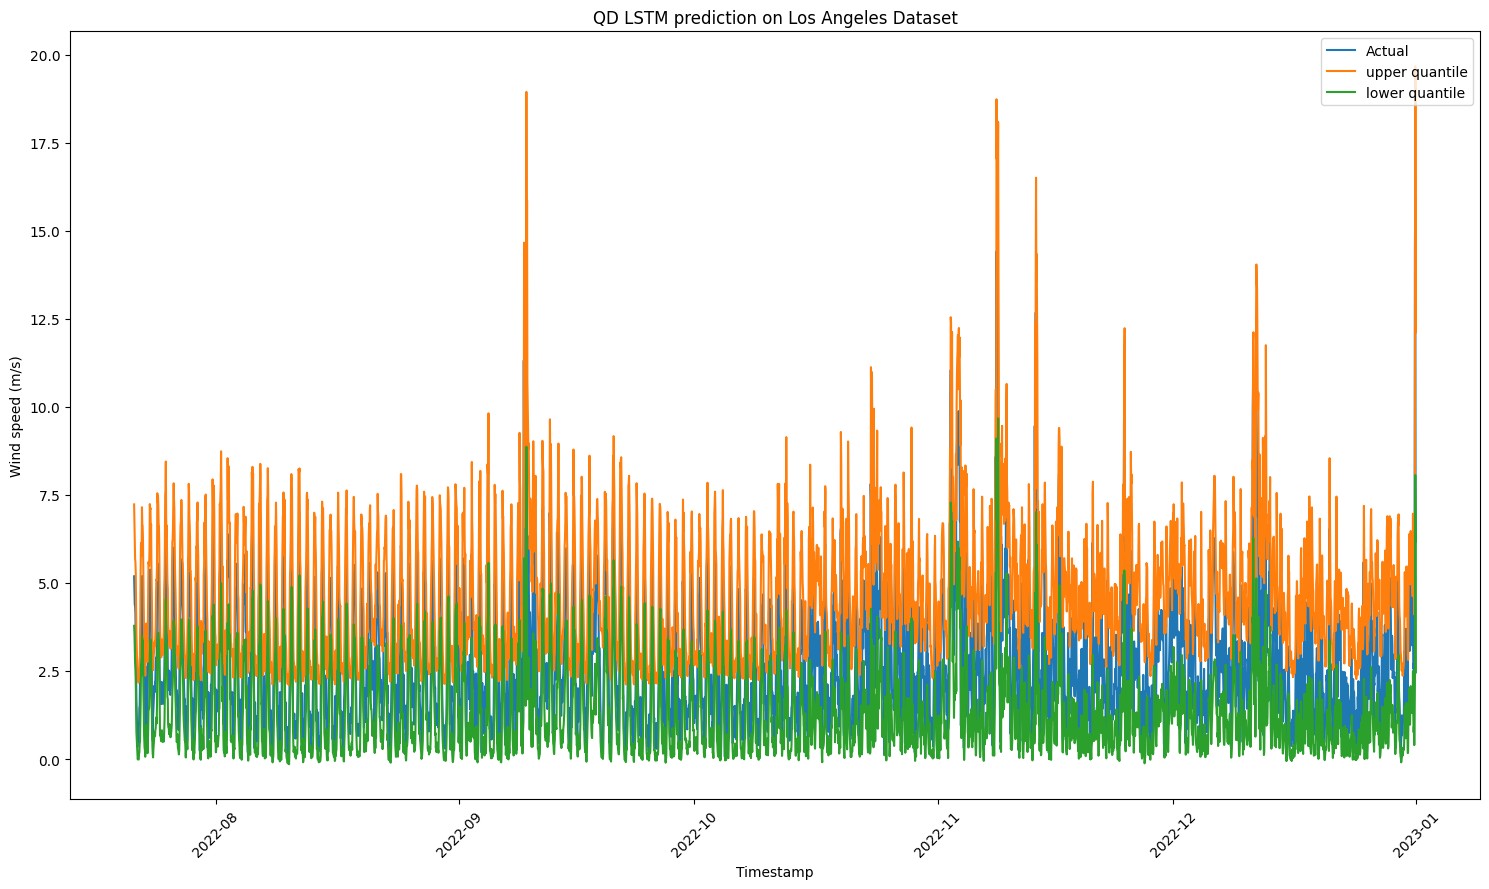

In [31]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(15, 9))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('QD LSTM prediction on Los Angeles Dataset')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('k_lstm_tube')
plt.show()

###### QD GRU

In [32]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()

for dropout in [0.1]:
    for layers in [[128]]:
        for alp in [0.05]:
            for sof in [160]:
                for l1 in [2]:
                    for l2 in [0.007]:
                        gru_model = create_gru((input_window_size, 1), layers, 2, dropout)
                        change_qd_var(alp, sof, 128, l1, l2)
                        gru_model.compile(loss=qd_objective, optimizer=Adam(learning_rate=0.001))
                        epc = 300
                        stop_patience = 10
                        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
                        start_time = datetime.datetime.now()
                        history = gru_model.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128, validation_data=(val_x, val_y), callbacks=[early_stopping])
                        end_time = datetime.datetime.now()
                        total_time = end_time - start_time
                        total_time = round(total_time.total_seconds(), 2)
                        print('seconds taken:', total_time, '\nstart_time:', start_time.strftime('%H:%M:%S'), 'end_time:', end_time.strftime('%H:%M:%S'))
                        y_pred = gru_model.predict(test_x, verbose=0)
                        y_pred = scaler_y.inverse_transform(y_pred)
                        test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
                        test_y_ = np.squeeze(test_y_[:,0])
                        y_u_pred = y_pred[:,0]
                        y_l_pred = y_pred[:,1]
                        K_u = y_u_pred > test_y_
                        K_l = y_l_pred < test_y_
                        PICP = np.mean(K_u * K_l)
                        MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
                        print('PICP:', PICP)
                        print('MPIW:', MPIW)
                        save_to_csv("qd_"+savefilename, dataset, "QD_GRU", PICP, MPIW, total_time, stop_patience, input_window_size, alpha_, soften_, n_, lambda1, lambda2, layers, dropout)

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 4.6154 - val_loss: 0.7443
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6424 - val_loss: 0.6420
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5970 - val_loss: 0.6652
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5824 - val_loss: 0.5563
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5332 - val_loss: 0.6318
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5440 - val_loss: 0.5275
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5458 - val_loss: 0.5826
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5649 - val_loss: 0.5171
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5529 - val_loss: 0.6037
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5710 - val_loss: 0.5816
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5249 - val_loss: 0.6076
Epoch 12/300
144/144 ━━━━━━━━━━━━━━━━━━━

In [33]:
gru_model.save('j_gru_qd.keras')

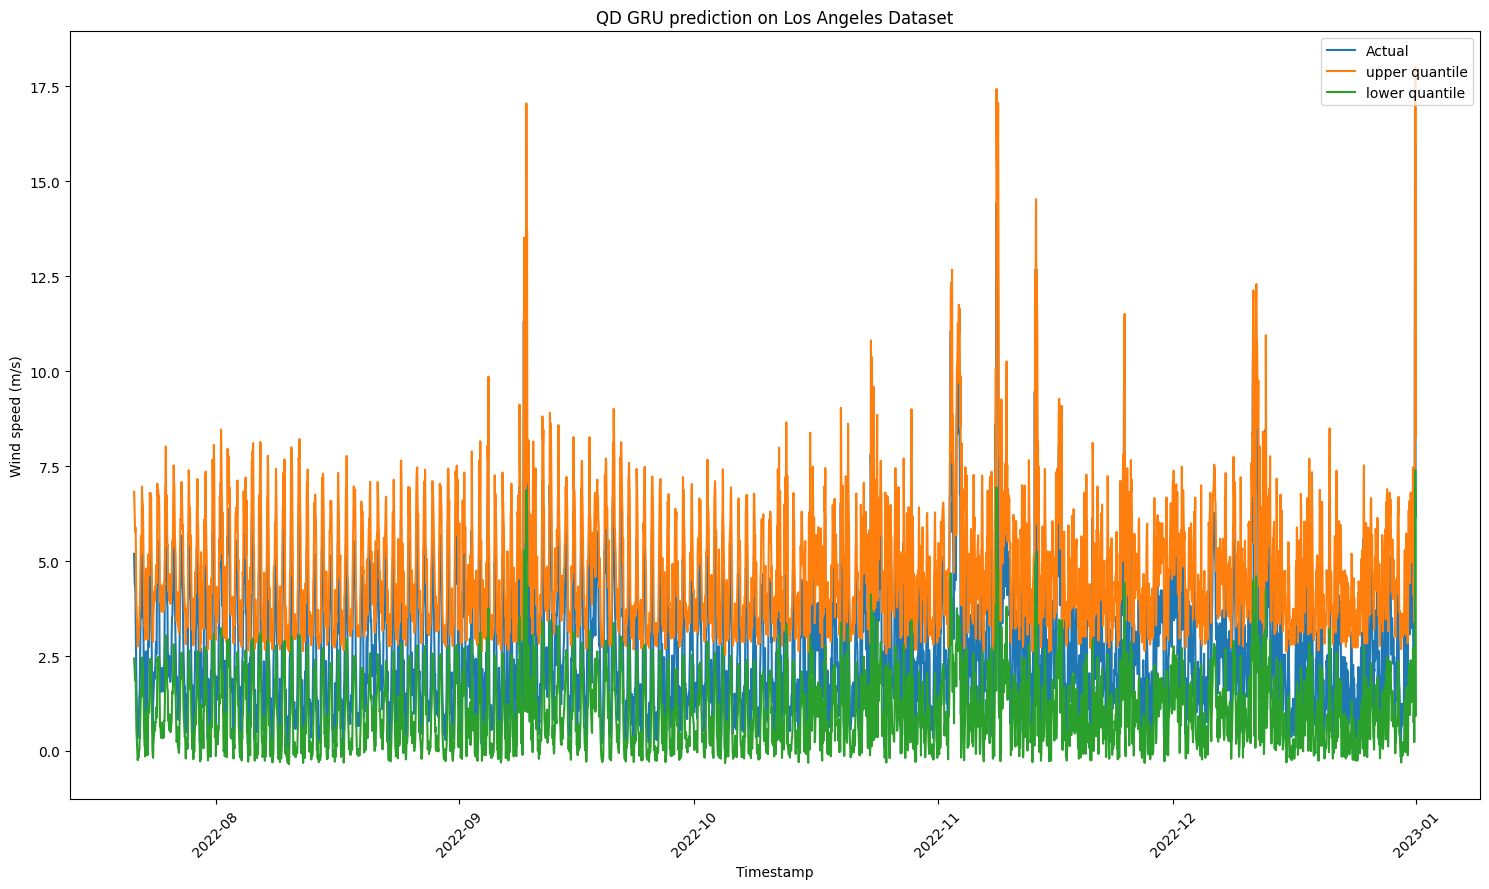

In [34]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(15, 9))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('QD GRU prediction on Los Angeles Dataset')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('k_lstm_tube')
plt.show()

###### QD TCN

In [35]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()

for dropout in [0.1]:
    for kernel in [3]:
        for layers in [[128]]:
            for alp in [0.05]:
                for sof in [160]:
                    for l1 in [5]:
                        for l2 in [0.05]:
                            change_qd_var(alp, sof, 128, l1, l2)
                            tcn_model = create_tcn((input_window_size,1), layers, kernel, dropout)
                            tcn_model.compile(loss=qd_objective, optimizer=Adam(learning_rate=0.001))
                            epc = 300
                            stop_patience = 10
                            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
                            start_time = datetime.datetime.now()
                            history = tcn_model.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128, validation_data=(val_x, val_y), callbacks=[early_stopping])
                            end_time = datetime.datetime.now()
                            total_time = end_time - start_time
                            total_time = round(total_time.total_seconds(), 2)
                            print('seconds taken:', total_time, '\nstart_time:', start_time.strftime('%H:%M:%S'), 'end_time:', end_time.strftime('%H:%M:%S'))
                            y_pred = tcn_model.predict(test_x, verbose=0)
                            y_pred = scaler_y.inverse_transform(y_pred)
                            test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
                            test_y_ = np.squeeze(test_y_[:,0])
                            y_u_pred = y_pred[:,0]
                            y_l_pred = y_pred[:,1]
                            K_u = y_u_pred > test_y_
                            K_l = y_l_pred < test_y_
                            PICP = np.mean(K_u * K_l)
                            MPIW = np.round(np.mean(y_u_pred - y_l_pred), 3)
                            print('PICP:', PICP)
                            print('MPIW:', MPIW)
                            save_to_csv("qd_"+savefilename, dataset, "TCN", PICP, MPIW, total_time, stop_patience, input_window_size, alpha_, soften_, n_, lambda1, lambda2, layers, dropout, kernel, "improve")

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 121.3275 - val_loss: 121.1721
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 121.1570 - val_loss: 121.1626
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 121.1507 - val_loss: 121.1499
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 121.1440 - val_loss: 121.1736
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 121.1565 - val_loss: 121.1896
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 121.2197 - val_loss: 121.1465
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 121.1419 - val_loss: 121.1479
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 121.1405 - val_loss: 121.1454
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 121.1397 - val_loss: 121.1455
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 121.1393 - val_loss: 121.1426
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 121.1386 - val_loss: 121.1

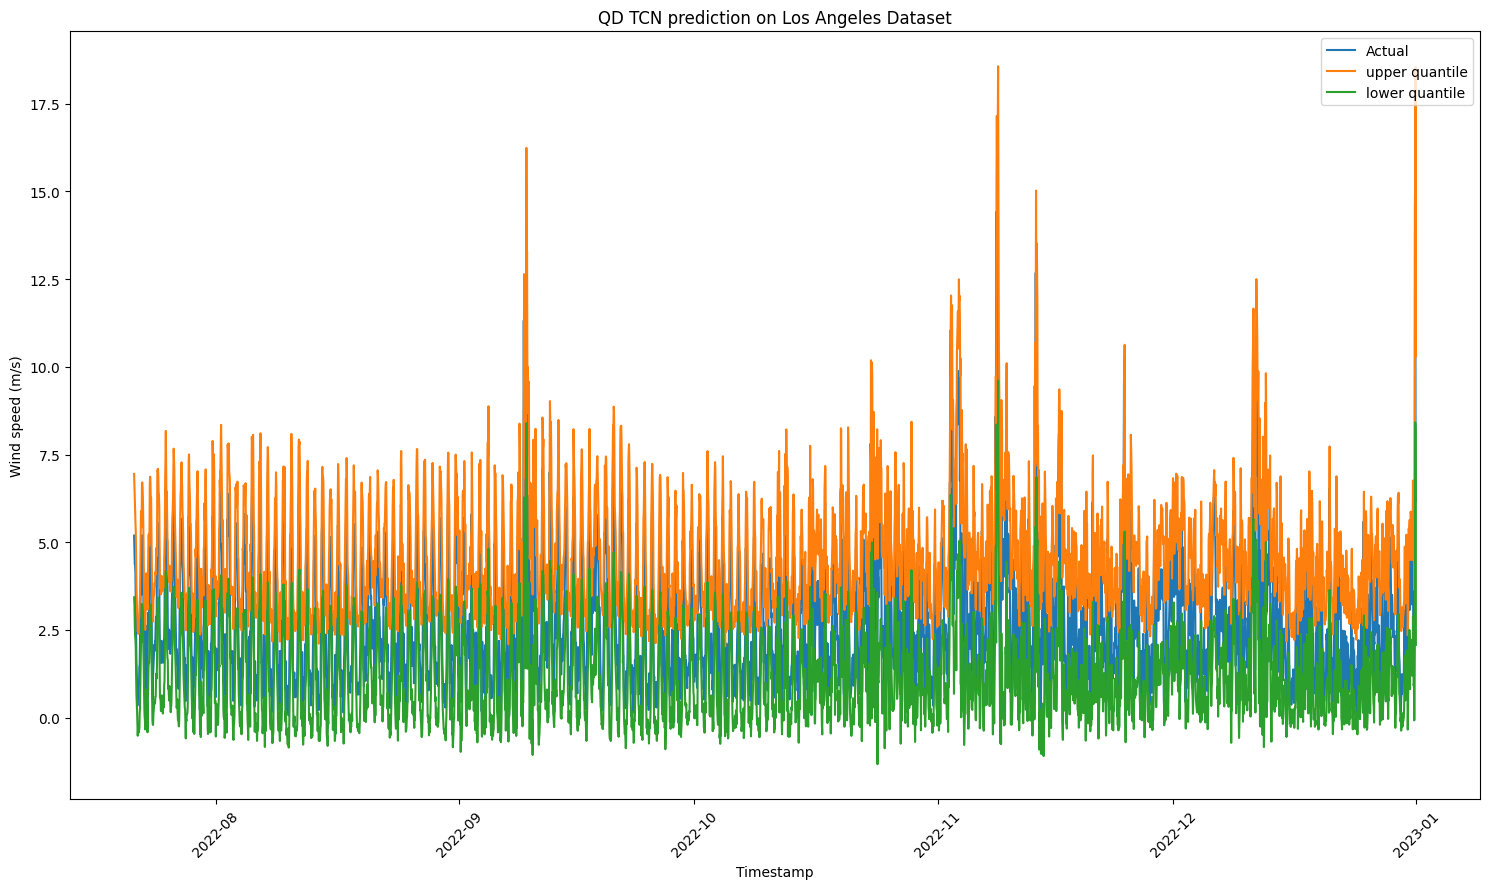

In [36]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(15, 9))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('QD TCN prediction on Los Angeles Dataset')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('k_lstm_tube')
plt.show()

In [37]:
tcn_model.save('j_tcn_qd.keras')

##### Confidence Loss

###### Confidence LSTM

In [38]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()

for layers in [[32,32]]:
    for ri in [0.5]:
        for qi in [0.95]:
            for deltai in [0.00017]:
                change_confidence_var(ri, qi, deltai)
                Confidence = create_lstm((input_window_size,1),layers,2)
                Confidence.compile(loss=confidence_loss,optimizer=Adam(learning_rate=0.005))
                epc = 300
                stop_patience = 10
                early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
                start_time = datetime.datetime.now()
                history = Confidence.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
                end_time = datetime.datetime.now()
                total_time = end_time - start_time
                total_time = round(total_time.total_seconds(),2)
                print('seconds taken:', total_time, '\nstart_time:', start_time.strftime('%H:%M:%S'), 'end_time:', end_time.strftime('%H:%M:%S'))
                y_pred = Confidence.predict(test_x, verbose=0)
                y_pred = scaler_y.inverse_transform(y_pred)
                test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
                test_y_ = np.squeeze(test_y_[:,0])
                y_u_pred = y_pred[:,0]
                y_l_pred = y_pred[:,1]
                K_u = y_u_pred > test_y_
                K_l = y_l_pred < test_y_
                PICP = np.mean(K_u * K_l)
                MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
                print('PICP:', PICP)
                print('MPIW:', MPIW)
                save_to_csv(savefilename, dataset, "Confidence_LSTM", PICP, MPIW, total_time, stop_patience, input_window_size, r, q, delta, layers)

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0274 - val_loss: 0.0134
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0118 - val_loss: 0.0109
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0100 - val_loss: 0.0106
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0095 - val_loss: 0.0099
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0093 - val_loss: 0.0100
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0091 - val_loss: 0.0097
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0091 - val_loss: 0.0097
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0090 - val_loss: 0.0099
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0089 - val_loss: 0.0097
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0089 - val_loss: 0.0095
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0088 - val_loss: 0.0095
Epoch 12/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/ste

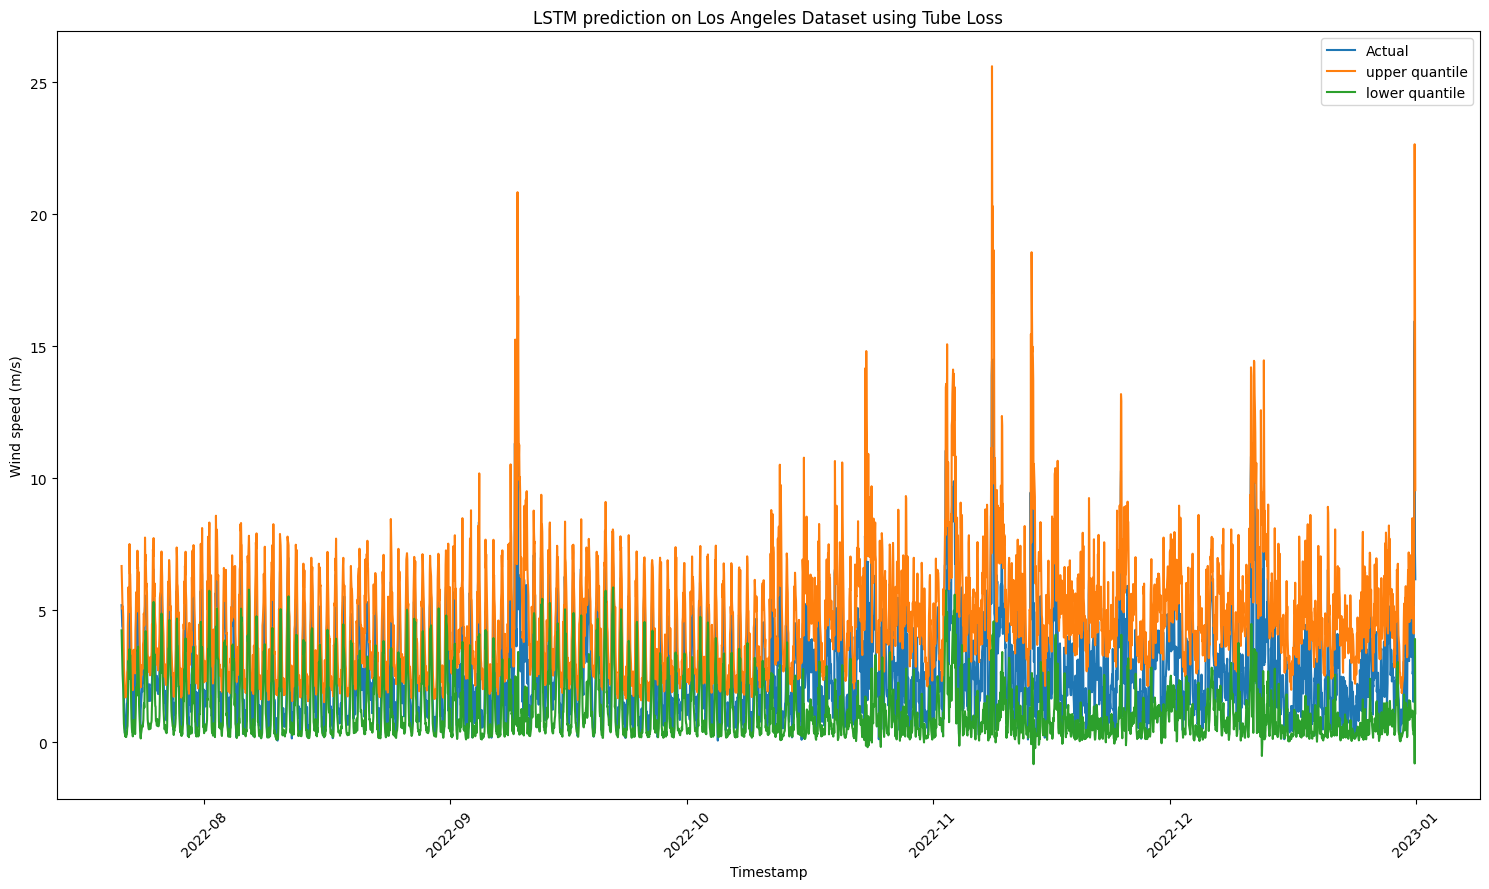

In [39]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(15, 9))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('LSTM prediction on Los Angeles Dataset using Tube Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('k_lstm_tube')
plt.show()

In [40]:
Confidence.save('j_LSTM_Confidence.keras')

###### Confidence GRU

In [41]:
#q1 = 0.975
#deltai = 0.004
#learning_rate = 0.001

In [42]:
'''
qi = 0.95
deltai = 0.004
learning_rate = 0.001
'''

'\nqi = 0.95\ndeltai = 0.004\nlearning_rate = 0.001\n'

In [43]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()

for dropout in [0.1]:
    for layers in [[16,16]]:
        for ri in [0.5]:
            for qi in [0.95]:
                for deltai in [0.005]:
                    change_confidence_var(ri, qi, deltai)
                    Confidence_GRU = create_gru((input_window_size,1),layers,2,dropout)
                    Confidence_GRU.compile(loss=confidence_loss,optimizer=Adam(learning_rate=0.0005))
                    epc = 300
                    stop_patience = 10
                    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
                    start_time = datetime.datetime.now()
                    history = Confidence_GRU.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
                    end_time = datetime.datetime.now()
                    total_time = end_time - start_time
                    total_time = round(total_time.total_seconds(),2)
                    print('seconds taken:', total_time, '\nstart_time:', start_time.strftime('%H:%M:%S'), 'end_time:', end_time.strftime('%H:%M:%S'))
                    y_pred = Confidence_GRU.predict(test_x, verbose=0)
                    y_pred = scaler_y.inverse_transform(y_pred)
                    test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
                    test_y_ = np.squeeze(test_y_[:,0])
                    y_u_pred = y_pred[:,0]
                    y_l_pred = y_pred[:,1]
                    K_u = y_u_pred > test_y_
                    K_l = y_l_pred < test_y_
                    PICP = np.mean(K_u * K_l)
                    MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
                    print('PICP:', PICP)
                    print('MPIW:', MPIW)
                    save_to_csv(savefilename, dataset, "Confidence_GRU", PICP, MPIW, total_time, stop_patience, input_window_size, r, q, delta,layers, dropout)


Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0689 - val_loss: 0.0176
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0175 - val_loss: 0.0152
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0156 - val_loss: 0.0137
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0145 - val_loss: 0.0128
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0136 - val_loss: 0.0127
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0131 - val_loss: 0.0122
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0126 - val_loss: 0.0119
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0125 - val_loss: 0.0116
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0123 - val_loss: 0.0115
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0119 - val_loss: 0.0113
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0119 - val_loss: 0.0112
Epoch 12/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/s

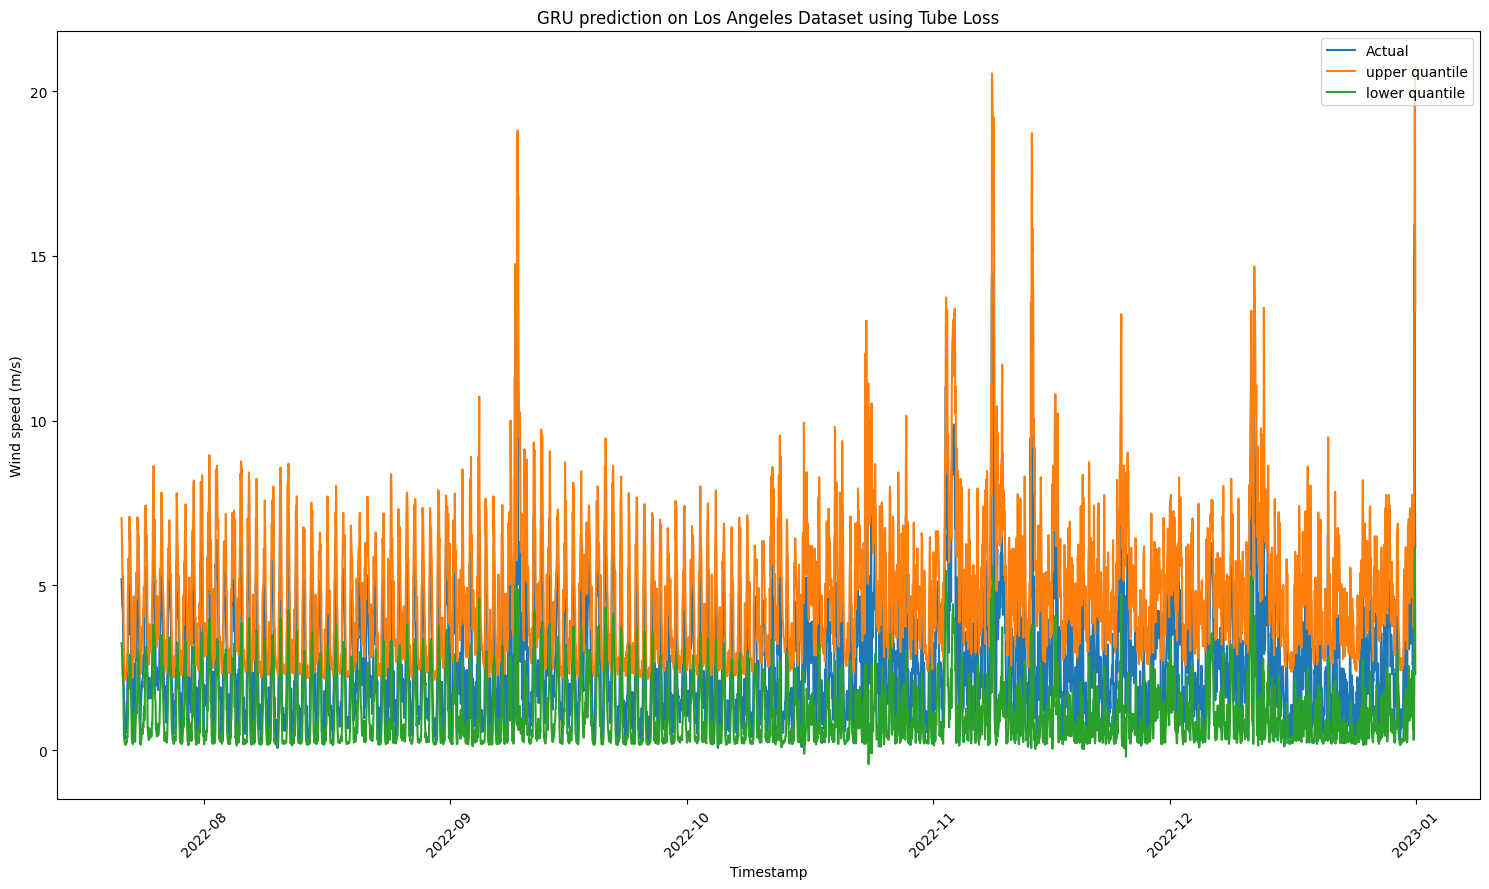

In [44]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(15, 9))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('GRU prediction on Los Angeles Dataset using Tube Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('k_lstm_tube')
plt.show()

In [45]:
Confidence_GRU.save('j_GRU_Confidence.keras')

###### Confidence TCN

In [46]:
#delta = 0.004, 0.0001
#learning_rate = 0.001, 0.0005

In [47]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()

for dropout in [0.1]:
    for kernel in [3]:
        for layers in [[128]]:
            for ri in [0.5]:
                for qi in [0.95]:
                    for deltai in [0.0001]:
                        change_confidence_var(ri, qi, deltai)
                        tcn_Confidence = create_tcn(input_shape=(input_window_size,1),
                                               filters_list=layers,
                                               kernel_size=kernel,
                                               dropout_rate=dropout)
                        tcn_Confidence.compile(loss=confidence_loss, optimizer=Adam(learning_rate=0.0005))
                        epc = 300
                        stop_patience = 10
                        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
                        start_time = datetime.datetime.now()
                        history = tcn_Confidence.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128, validation_data=(val_x, val_y), callbacks=[early_stopping])
                        end_time = datetime.datetime.now()
                        total_time = end_time - start_time
                        total_time = round(total_time.total_seconds(),2)
                        print('seconds taken:', total_time, '\nstart_time:', start_time.strftime('%H:%M:%S'), 'end_time:', end_time.strftime('%H:%M:%S'))
                        y_pred = tcn_Confidence.predict(test_x, verbose=0)
                        y_pred = scaler_y.inverse_transform(y_pred)
                        test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
                        test_y_ = np.squeeze(test_y_[:,0])
                        y_u_pred = y_pred[:,0]
                        y_l_pred = y_pred[:,1]
                        K_u = y_u_pred > test_y_
                        K_l = y_l_pred < test_y_
                        PICP = np.mean(K_u * K_l)
                        MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
                        print('PICP:', PICP)
                        print('MPIW:', MPIW)
                        save_to_csv(savefilename, dataset, "Confidence_TCN", PICP, MPIW, total_time, stop_patience, input_window_size, r, q, delta, layers, dropout, kernel)

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0286 - val_loss: 0.0108
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0101 - val_loss: 0.0096
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0095
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - val_loss: 0.0092
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - val_loss: 0.0084
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - val_loss: 0.0084
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - val_loss: 0.0086
Epoch 12/300
144/144 ━━━━━━━━━━━━━━━━━━━

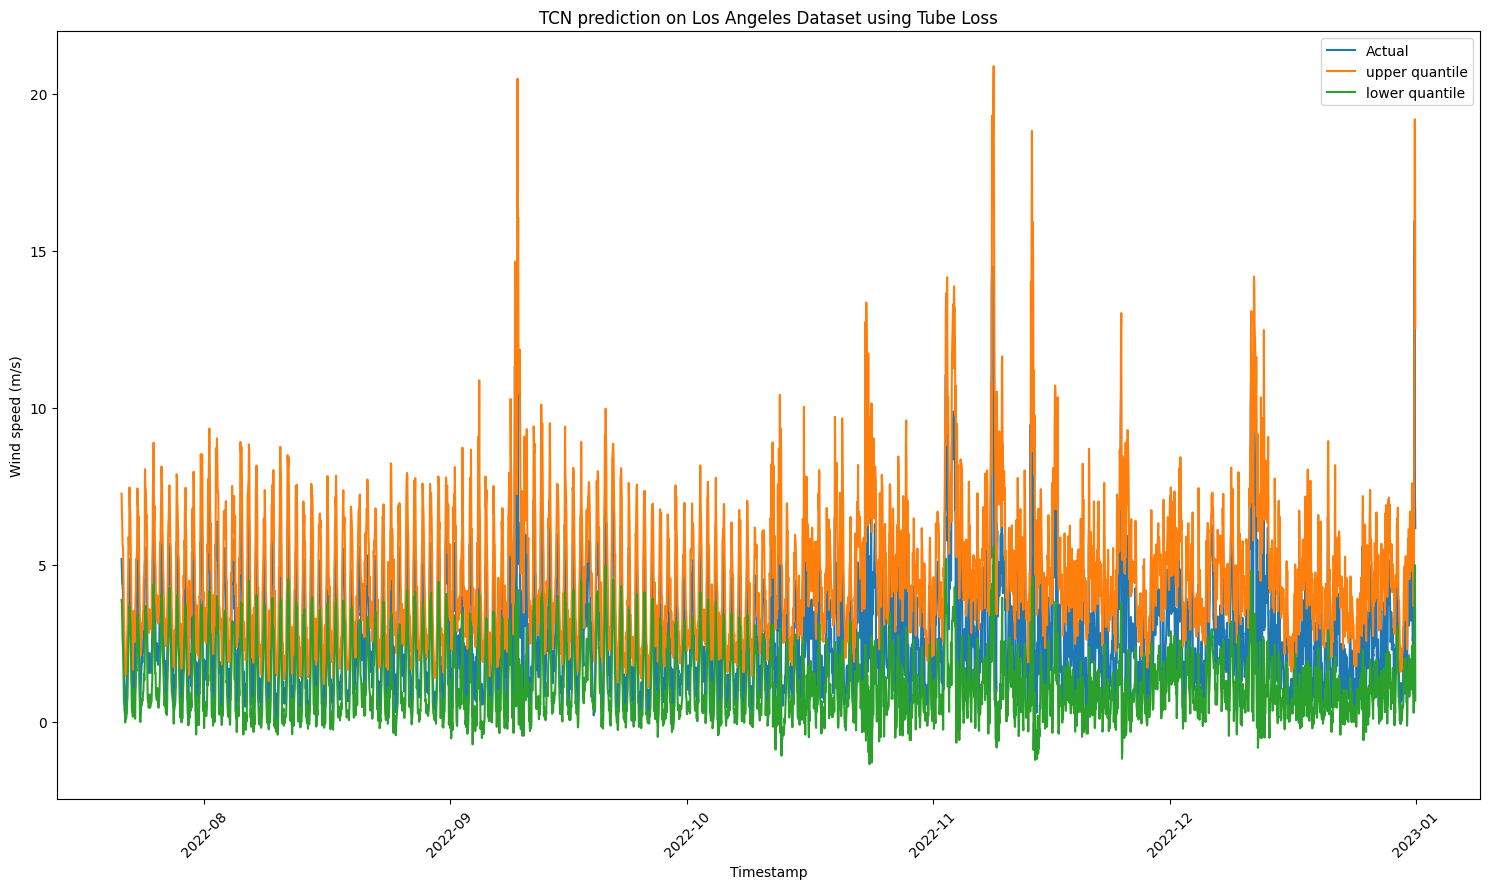

In [48]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(15, 9))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('TCN prediction on Los Angeles Dataset using Tube Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('k_lstm_tube')
plt.show()

In [49]:
tcn_Confidence.save('j_TCN_Confidence.keras')

##### Quantile Loss

###### Quantile LSTM

In [50]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()

In [51]:
layers = [128]
dropout = 0
quantile1 = create_lstm((input_window_size,1),layers,1,dropout)
quantile2 = create_lstm((input_window_size,1),layers,1,dropout)

In [52]:
q1=0.03
q2=0.98
quantile1.compile(loss=quantile_loss(q1),optimizer=Adam(learning_rate=0.001))
quantile2.compile(loss=quantile_loss(q2),optimizer=Adam(learning_rate=0.001))

In [53]:
epc = 300
stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile1.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time = end_time - start_time
total_time1 = round(total_time.total_seconds(),2)
print('seconds taken:', total_time1,
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0041 - val_loss: 0.0044
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 12/300
144/144 ━━━━━━━━━━━━━━━━━━━

In [54]:
epc = 300
stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile2.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time = end_time - start_time
total_time2 = round(total_time.total_seconds(),2)
print('seconds taken:', total_time2,
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0243 - val_loss: 0.0057
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 12/300
144/144 ━━━━━━━━━━━━━━━━━━━

In [55]:
y_l_pred = quantile1.predict(test_x, verbose=0)
y_u_pred = quantile2.predict(test_x, verbose=0)
test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
# test_y_ = np.squeeze(test_y_[:,0])
y_l_pred = scaler_y.inverse_transform(y_l_pred)
y_u_pred = scaler_y.inverse_transform(y_u_pred)
K_u = y_u_pred > test_y_
K_l = y_l_pred < test_y_
PICP = np.mean(K_u * K_l)
MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
print('PICP:', PICP)
print('MPIW:', MPIW)

PICP: 0.9574196838347782
MPIW: 4.001


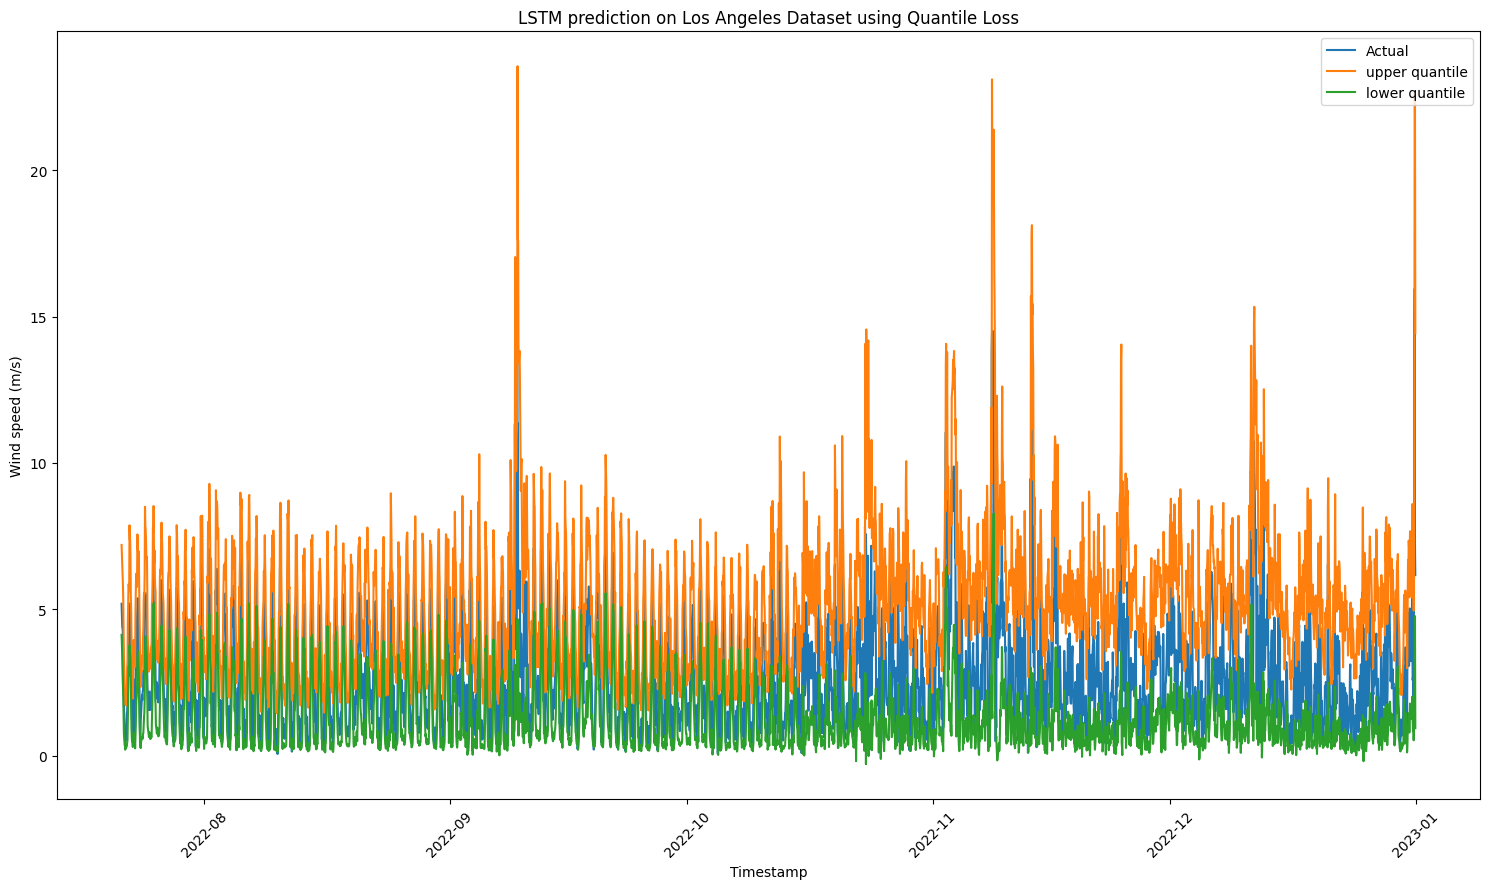

In [56]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(15, 9))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('LSTM prediction on Los Angeles Dataset using Quantile Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('k_lstm_tube')
plt.show()

In [57]:
save_to_csv("quantile_"+savefilename, dataset, "Quantile_LSTM", PICP, MPIW, total_time1 + total_time2, stop_patience, input_window_size, q1, q2, layers, dropout)

Data appended successfully to quantile_LosAngeles.csv


In [58]:
quantile1.save('j_lstm_q1.keras')
quantile2.save('j_lstm_q2.keras')

###### Quantile GRU

In [59]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()

In [60]:
layers = [128]
dropout = 0
quantile1 = create_gru((input_window_size,1),layers,1,dropout)
quantile2 = create_gru((input_window_size,1),layers,1,dropout)

In [61]:
q1=0.025
q2=0.975
quantile1.compile(loss=quantile_loss(q1),optimizer=Adam(learning_rate=0.001))
quantile2.compile(loss=quantile_loss(q2),optimizer=Adam(learning_rate=0.001))

In [62]:
epc = 300
stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile1.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time = end_time - start_time
total_time1 = round(total_time.total_seconds(),2)
print('seconds taken:', total_time1,
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 12/300
144/144 ━━━━━━━━━━━━━━━━━━━

In [63]:
epc = 300
stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile2.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time = end_time - start_time
total_time2 = round(total_time.total_seconds(),2)
print('seconds taken:', total_time2,
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0227 - val_loss: 0.0055
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 12/300
144/144 ━━━━━━━━━━━━━━━━━━━

In [64]:
y_l_pred = quantile1.predict(test_x, verbose=0)
y_u_pred = quantile2.predict(test_x, verbose=0)
test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
# test_y_ = np.squeeze(test_y_[:,0])
y_l_pred = scaler_y.inverse_transform(y_l_pred)
y_u_pred = scaler_y.inverse_transform(y_u_pred)
K_u = y_u_pred > test_y_
K_l = y_l_pred < test_y_
PICP = np.mean(K_u * K_l)
MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
print('PICP:', PICP)
print('MPIW:', MPIW)

PICP: 0.9510453850076491
MPIW: 3.618


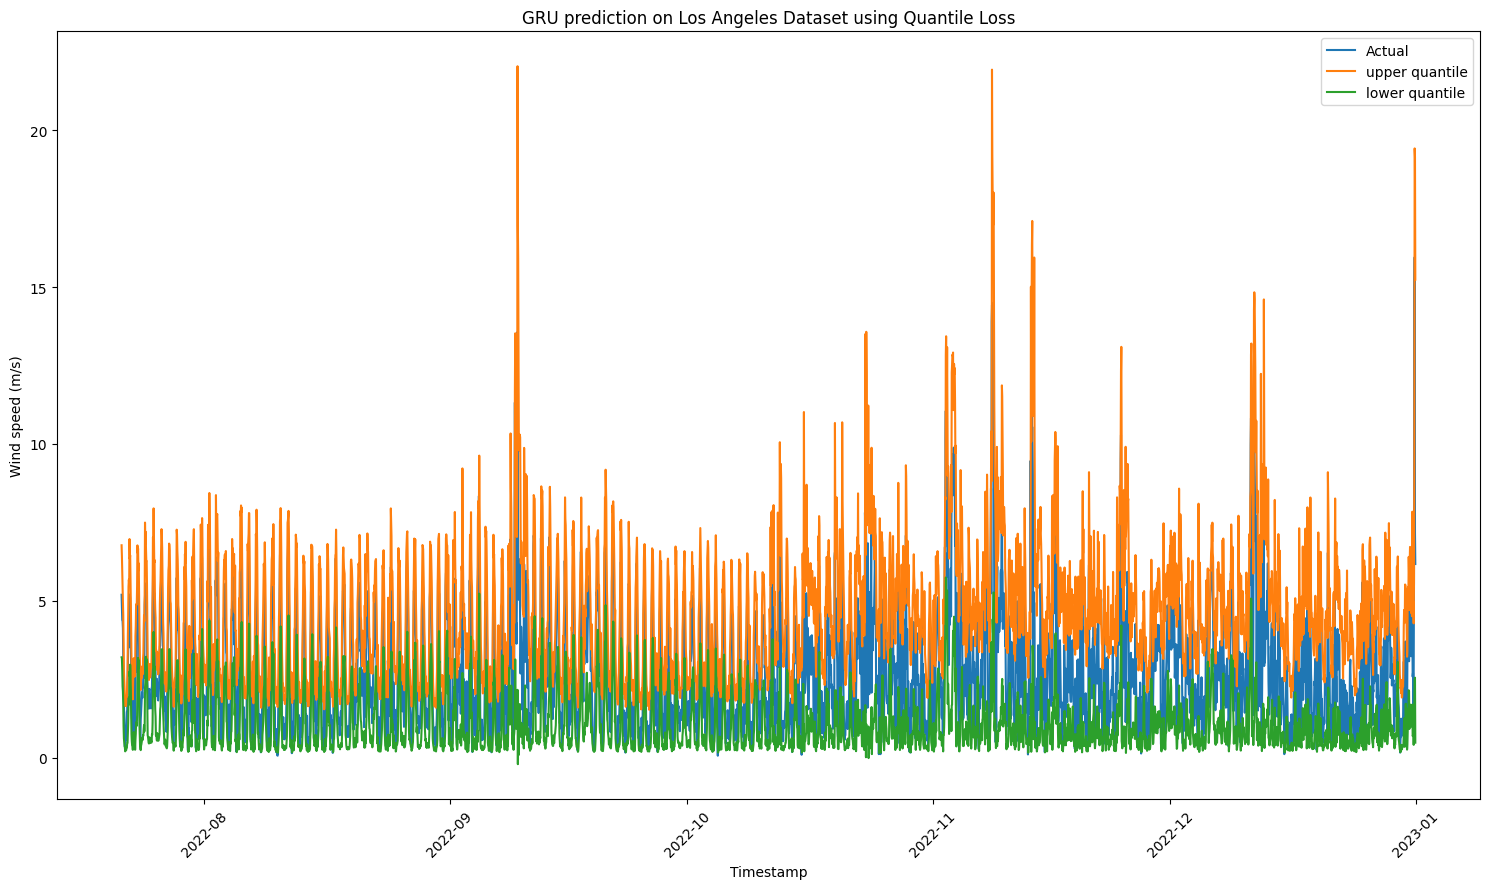

In [65]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(15, 9))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('GRU prediction on Los Angeles Dataset using Quantile Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('k_lstm_tube')
plt.show()

In [66]:
save_to_csv("quantile_"+savefilename, dataset, "Quantile_GRU", PICP, MPIW, total_time1 + total_time2, stop_patience, input_window_size, q1, q2, layers, dropout)

Data appended successfully to quantile_LosAngeles.csv


In [67]:
quantile1.save('j_gru_q1.keras')
quantile2.save('j_gru_q2.keras')

###### Quantile TCN

In [68]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()

In [69]:
layers = [128]
dropout = 0.1
kernel = 5
quantile1 = create_tcn((input_window_size,1), layers, kernel, dropout)
quantile2 = create_tcn((input_window_size,1), layers, kernel, dropout)

In [70]:
q1=0.025
q2=0.975
quantile1.compile(loss=quantile_loss(q1),optimizer=Adam(learning_rate=0.001))
quantile2.compile(loss=quantile_loss(q2),optimizer=Adam(learning_rate=0.001))

In [71]:
epc = 300
stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile1.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time = end_time - start_time
total_time1 = round(total_time.total_seconds(),2)
print('seconds taken:', total_time1,
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 12/300
144/144 ━━━━━━━━━━━━━━━━━━━

In [72]:
epc = 300
stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile2.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time = end_time - start_time
total_time2 = round(total_time.total_seconds(),2)
print('seconds taken:', total_time2,
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0138 - val_loss: 0.0055
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 12/300
144/144 ━━━━━━━━━━━━━━━━━━━

In [73]:
y_l_pred = quantile1.predict(test_x, verbose=0)
y_u_pred = quantile2.predict(test_x, verbose=0)
test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
# test_y_ = np.squeeze(test_y_[:,0])
y_l_pred = scaler_y.inverse_transform(y_l_pred)
y_u_pred = scaler_y.inverse_transform(y_u_pred)
K_u = y_u_pred > test_y_
K_l = y_l_pred < test_y_
PICP = np.mean(K_u * K_l)
MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
print('PICP:', PICP)
print('MPIW:', MPIW)

PICP: 0.9416114227434982
MPIW: 3.779


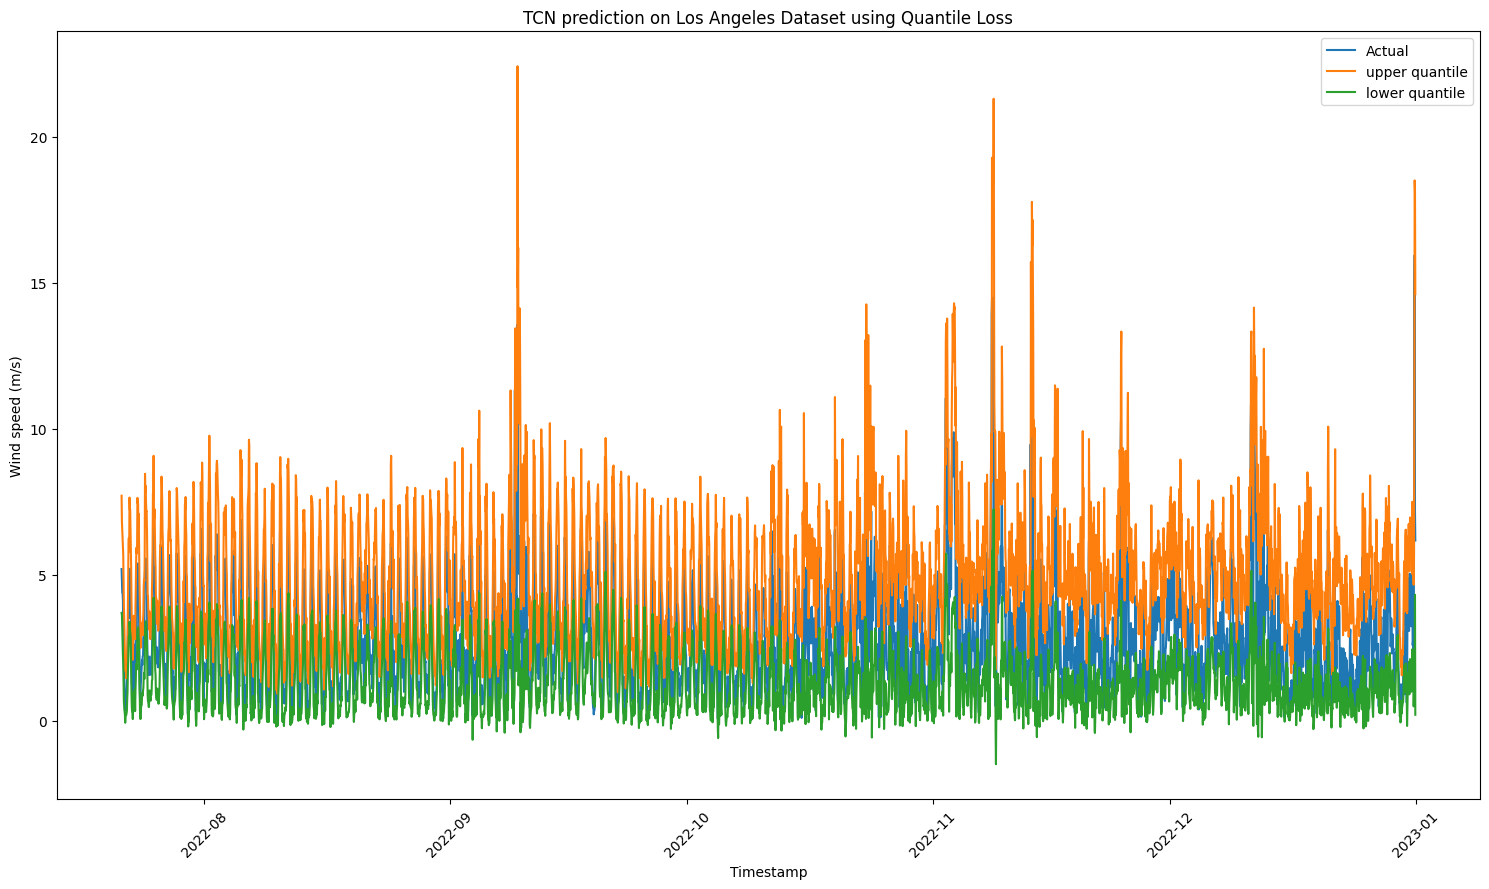

In [74]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred[:,:1]
pred2=y_l_pred[:,:1]
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(15, 9))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('TCN prediction on Los Angeles Dataset using Quantile Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('k_lstm_tube')
plt.show()

In [75]:
save_to_csv("quantile_"+savefilename, dataset, "Quantile_TCN", PICP, MPIW, total_time1 + total_time2, stop_patience, input_window_size, q1, q2, layers, dropout, kernel)

Data appended successfully to quantile_LosAngeles.csv


In [76]:
quantile1.save('j_tcn_q1.keras')
quantile2.save('j_tcn_q2.keras')